In [ ]:
import matplotlib.pyplot as plt
# Create labels for the x-axis (temperature ranges)
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import sys
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
import seaborn as sns

In [ ]:
config=read_config(os.path.join(GTE_DIR,'/config_half.yaml'))
t_deltas = config['t_deltas']
agg_fact = config['agg_fact']
min_temp_array, max_temp_array = config['min_temp_arr'],config['max_temp_arr']
folder_name=f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"

In [6]:
ice_cont_crit_frac=0.05

In [7]:
def Extract_array_from_df(series:pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [9]:

# Initialize an empty list to store the individual dataframes
cloud_properties_df_list = []

# Iterate over each temperature range
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]
    
    # Iterate over each pole
    for pole in config["pole_folders"]:
        # Construct the file path
        fp = os.path.join(
            config['postprocessing_output_dir'],
            pole,
            folder_name,
            f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
        )
        
        # Read the parquet file into a dataframe
        df = pd.read_parquet(fp)
        
        # Add columns for min_temp, max_temp, and pole
        df['min_temp'] = min_temp
        df['max_temp'] = max_temp
        df['pole'] = pole
        df['Hemisphere'] = "South" if pole == "sp" else "North"
        df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)
        
        # Append the dataframe to the sublist
        cloud_properties_df_list[i].append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat([df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)

In [15]:
combined_df['min_temp'].value_counts(sort=False)

min_temp
-5     26849
-10    33708
-15    35536
-20    35933
-25    35111
-30    33633
-35    30863
Name: count, dtype: int64

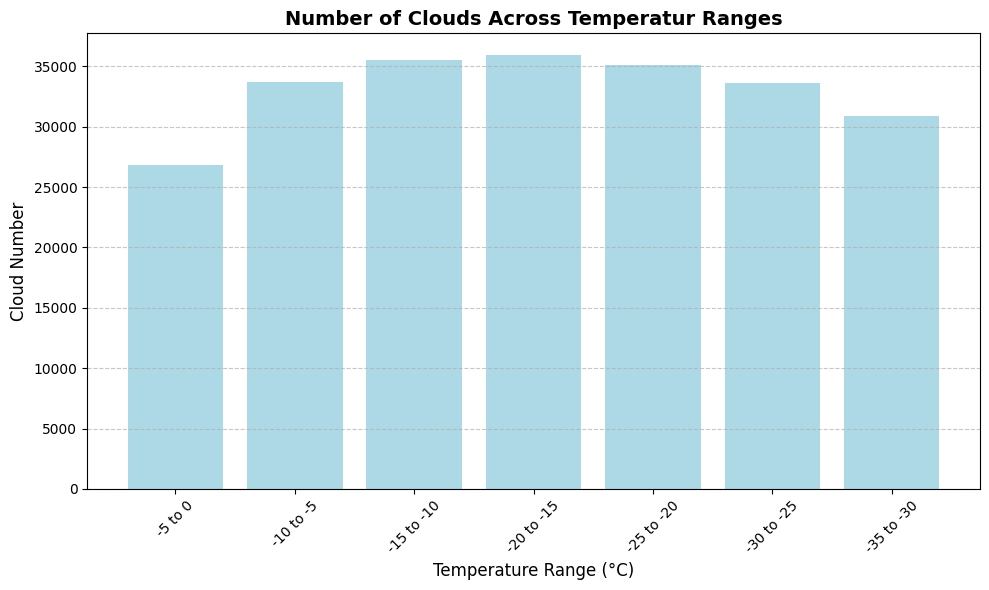

In [ ]:
# Create labels for the x-axis (temperature ranges)
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range( len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, combined_df['min_temp'].value_counts(sort=False).to_numpy(), color='lightblue', label="N glaciations")

# Add title and labels
plt.title('Number of Clouds Across Temperatur Ranges', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Cloud Number', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis to show only integer values
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,'/Result_graphs/cloud_temp_hist.png'), dpi=400)
plt.show()

In [39]:
# Total count of objects in each group
total_counts = combined_df.groupby('max_temp').size()

# Count of objects meeting the condition in each group
condition_counts = combined_df[combined_df['max_ice_fraction'] > ice_cont_crit_frac].groupby('max_temp').size()

# Fraction of objects meeting the condition in each group
fraction_ice_containing_clouds_by_dt = condition_counts / total_counts

# Fill NaN values with 0 (in case there are groups with no objects meeting the condition)
fraction_ice_containing_clouds_by_dt = fractions.fillna(0)
fraction_ice_containing_clouds_by_dt =fraction_ice_containing_clouds_by_dt.to_numpy()[::-1]


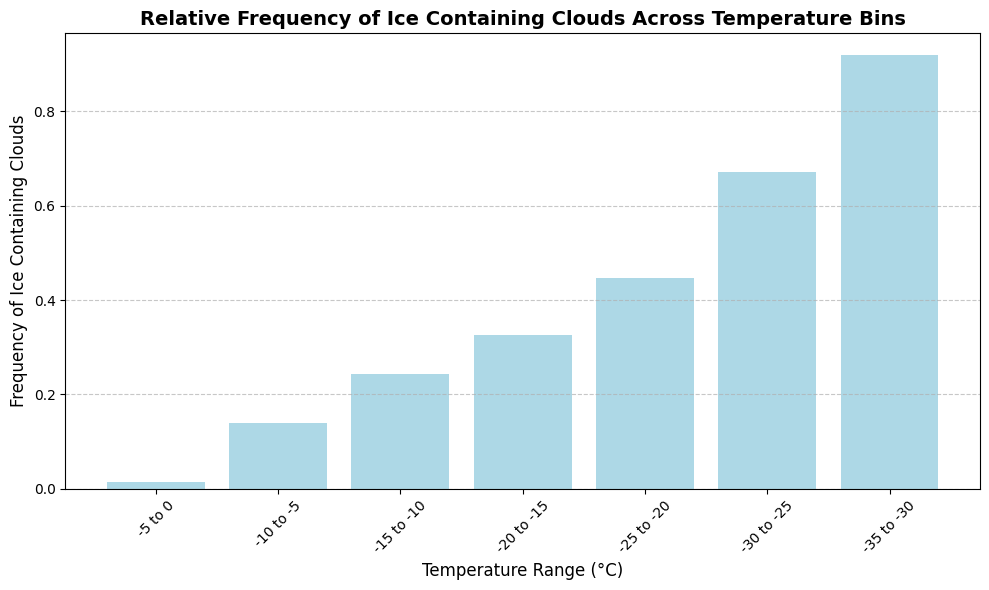

In [ ]:
# Create labels for the x-axis (temperature ranges)
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range( len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, fraction_ice_containing_clouds_by_dt, color='lightblue', label="N glaciations")

# Add title and labels
plt.title('Relative Frequency of Ice Containing Clouds Across Temperature Bins', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Frequency of Ice Containing Clouds', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis to show only integer values
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,'/Result_graphs/frac_ice_containging_clouds_bar_chart.png'), dpi=400)
plt.show()

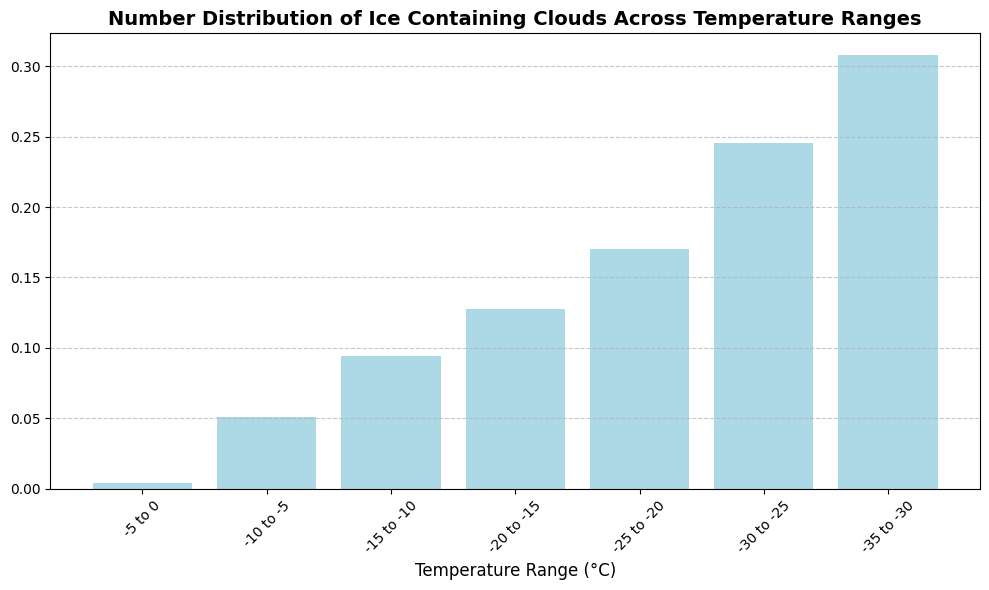

In [ ]:
# Create labels for the x-axis (temperature ranges)
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range( len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, combined_df[combined_df['max_ice_fraction'] > ice_cont_crit_frac]['min_temp'].value_counts(sort=False, normalize = True).to_numpy(), color='lightblue', label="N glaciations")

# Add title and labels
plt.title('Number Distribution of Ice Containing Clouds Across Temperature Ranges', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis to show only integer values
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,'/Result_graphs/ice_cloud_temp_hist.png'), dpi=400)
plt.show()

In [27]:
tmp_bin_array=np.arange(-80,81,10)

glaciation_counter_temp_agg_3=np.zeros(len(min_temp_array))
tmp_bins=pd.IntervalIndex.from_arrays(tmp_bin_array[0:-1],tmp_bin_array[1:])
# lat_bin_df= pd.DataFrame(np.zeros(len(tmp_bin_array)-1), index=tmp_bins,columns=["n_clouds"])
lat_bin_df = pd.DataFrame(np.zeros((len(tmp_bin_array) - 1,3)), index=tmp_bins, columns=["n_clouds", "cloud_area_sum", "cloud_px_sum"])


# Drop the biggest and smallest cloud from each group
def drop_min_max(group):
    n_drop=2
    if len(group) > n_drop*2:  # Ensure group has more than two elements
        group = group.sort_values("avg_size[km]")
        return group.iloc[n_drop:-n_drop]  # Drop first and last rows
    return group  # Return an empty DataFrame if not enough rows
combined_df=None
for i in range(len(min_temp_array)):
    for j in range(len(config['pole_folders'])):
        min_temp = min_temp_array[i]
        max_temp = max_temp_array[i]
        
        df = cloud_properties_df_list[i][j]
        
        glaciation_counter_temp_agg_3[i] += (df['is_liq'] & df['is_mix'] & df['is_ice']).astype(bool).sum(axis=0)
        df=df[df['avg_lat'].notna()]
        df=df[df['avg_size[km]'].notna()]
        df["lat_bin"] = pd.cut(df['avg_lat'], tmp_bin_array)
        
        # Filter rows where max_ice_fraction > 0
        filtered_df = df[df["max_ice_fraction"] > ice_cont_crit_frac]
        if combined_df is not None:
            combined_df=pd.concat([combined_df,filtered_df],axis=0)
        else:
            combined_df=filtered_df.copy()
        filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
        # Group by lat_bin and perform sum on "avg_size[km]"
        
        groups = filtered_df.groupby("lat_bin")
        
        # Update lat_bin_df for filtered data
        # Compute group sums and means
        group_sums_km = groups["avg_size[km]"].sum()
        group_sums_px = groups["avg_size[px]"].sum()

        # Fill NaN values in means with 0 (or another default value if necessary)
        # group_means = group_means.fillna(0)

        # Update lat_bin_df DataFrame
        lat_bin_df["cloud_px_sum"] += group_sums_px
        lat_bin_df["cloud_area_sum"] += group_sums_km
        lat_bin_df["n_clouds"] += groups.size()
        # lat_bin_df["time"]
        # # Debugging Outputs
        # print("sum:", group_sums)
        # print("mean:", group_means)\
lat_bin_df['cloud_area_avg'] = (lat_bin_df["cloud_area_sum"]/lat_bin_df["n_clouds"])
# lat_bin_df=lat_bin_df.dropna()
print(lat_bin_df['n_clouds'])
# lat_bin_df["n_clouds"]
# lat_bin_df["n_clouds"]
# pd.cut(df[df["max_ice_fraction"]>0]['avg_lat'].dropna(), tmp_bin_array)


/cluster/work/climate/dnikolo/dump/ipykernel_37352/3510928208.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
/cluster/work/climate/dnikolo/dump/ipykernel_37352/3510928208.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
/cluster/work/climate/dnikolo/dump/ipykernel_37352/3510928208.py:38: FutureWarning: The default of observed=False is 

(-80, -70]     5666.0
(-70, -60]    13542.0
(-60, -50]    14606.0
(-50, -40]    10612.0
(-40, -30]    10173.0
(-30, -20]     2331.0
(-20, -10]        0.0
(-10, 0]          0.0
(0, 10]           0.0
(10, 20]          0.0
(20, 30]       1934.0
(30, 40]      13206.0
(40, 50]       7899.0
(50, 60]       5218.0
(60, 70]       4124.0
(70, 80]       2504.0
Name: n_clouds, dtype: float64


/cluster/work/climate/dnikolo/dump/ipykernel_37352/3510928208.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
/cluster/work/climate/dnikolo/dump/ipykernel_37352/3510928208.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
/cluster/work/climate/dnikolo/dump/ipykernel_37352/3510928208.py:38: FutureWarning: The default of observed=False is 

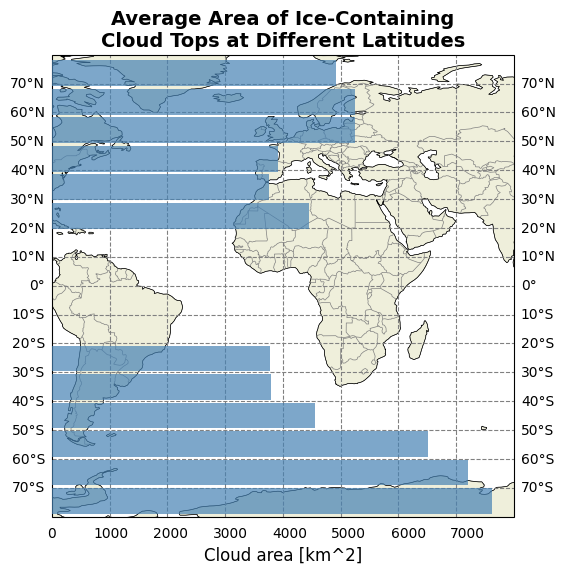

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Dummy data for illustration
# tmp_bin_array = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
# lat_bin_df = {"n_clouds": [5, 15, 20, 10, 25, 15, 10, 5]}

# Calculate midpoints and bin widths
latitudes = [(tmp_bin_array[i] + tmp_bin_array[i + 1] -1 ) / 2 for i in range(len(tmp_bin_array) - 1)]
bin_widths = [tmp_bin_array[i + 1] - tmp_bin_array[i] - 1 for i in range(len(tmp_bin_array) - 1)]

# Create the figure and map axes
fig = plt.figure(figsize=(10, 6))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-80, 80, -80, 80], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.2)
#n_steps=10,
# Add gridlines with specified latitude lines
gl = ax_map.gridlines(
    
    draw_labels=True,
    color='gray',
    linestyle='--',
    linewidth=0.8
)
gl.top_labels = False  # Disable labels on the top
gl.bottom_labels = False  # Disable labels on the bottom
# gl.right_labels = False  # Disable labels on the right

# Add specific latitudes for gridlines (including top and bottom latitudes)
latitudes_to_show = tmp_bin_array  # Include all latitude bin boundaries
gl.ylocator = plt.FixedLocator(latitudes_to_show)

# Create the second Axes for the bar chart, sharing the same extent
ax_bar = fig.add_axes(ax_map.get_position(), zorder=2)  # Align with the map
ax_bar.barh(latitudes, lat_bin_df["cloud_area_sum"]/lat_bin_df["n_clouds"], color='#4682B4',
            height=bin_widths, zorder=3, alpha=0.7)  # Use `height` for correct bin widths
# ax_bar.set_xscale("log")
# Remove the background of the bar chart (make transparent)
ax_bar.set_facecolor((1, 1, 1, 0))  # RGBA: white background, fully transparent

# Add title and labels for the bar chart
ax_bar.set_title('Average Area of Ice-Containing\nCloud Tops at Different Latitudes', fontsize=14, fontweight='bold')
ax_bar.set_xlabel('Cloud area [km^2]', fontsize=12)

# Remove the bar graph's y-axis labels
ax_bar.set_yticks([])  # Removes tick marks and labels on y-axis

# Set continuous latitude range for y-axis
ax_bar.set_ylim(tmp_bin_array[0] - 1, tmp_bin_array[-1] + 1)  # Full range of latitude bins

# Format x-axis to show only integer values
# ax_bar.xaxis.get_major_locator().set_params(integer=True)

# Hide axes ticks and spines for the bar chart (optional for cleaner overlay)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(left=False, bottom=False)

# Save and show the plot
plt.savefig(os.path.join(GTE_DIR,'/Result_graphs/Size_avg_ice_conaining_clouds_by_lat.png'), dpi=400)
plt.show()


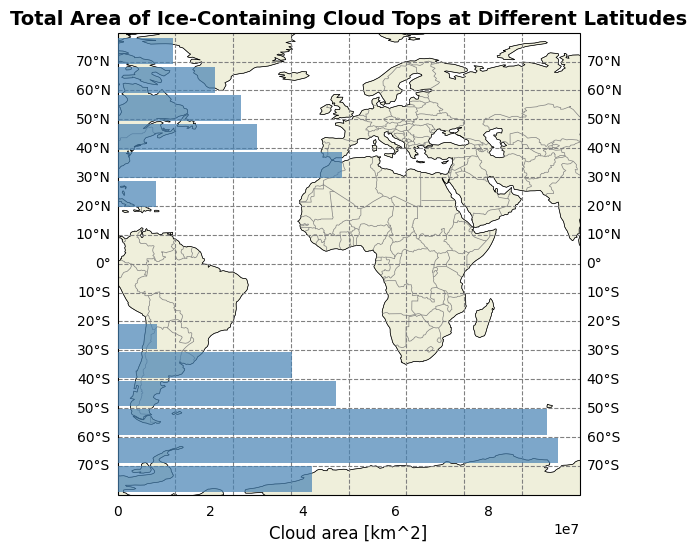

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Dummy data for illustration
# tmp_bin_array = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
# lat_bin_df = {"n_clouds": [5, 15, 20, 10, 25, 15, 10, 5]}

# Calculate midpoints and bin widths
latitudes = [(tmp_bin_array[i] + tmp_bin_array[i + 1] -1 ) / 2 for i in range(len(tmp_bin_array) - 1)]
bin_widths = [tmp_bin_array[i + 1] - tmp_bin_array[i] - 1 for i in range(len(tmp_bin_array) - 1)]

# Create the figure and map axes
fig = plt.figure(figsize=(10, 6))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-80, 80, -80, 80], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.2)
#n_steps=10,
# Add gridlines with specified latitude lines
gl = ax_map.gridlines(
    
    draw_labels=True,
    color='gray',
    linestyle='--',
    linewidth=0.8
)
gl.top_labels = False  # Disable labels on the top
gl.bottom_labels = False  # Disable labels on the bottom
# gl.right_labels = False  # Disable labels on the right

# Add specific latitudes for gridlines (including top and bottom latitudes)
latitudes_to_show = tmp_bin_array  # Include all latitude bin boundaries
gl.ylocator = plt.FixedLocator(latitudes_to_show)

# Create the second Axes for the bar chart, sharing the same extent
ax_bar = fig.add_axes(ax_map.get_position(), zorder=2)  # Align with the map
ax_bar.barh(latitudes, lat_bin_df["cloud_area_sum"], color='#4682B4',
            height=bin_widths, zorder=3, alpha=0.7)  # Use `height` for correct bin widths
# ax_bar.set_xscale("log")
# Remove the background of the bar chart (make transparent)
ax_bar.set_facecolor((1, 1, 1, 0))  # RGBA: white background, fully transparent

# Add title and labels for the bar chart
ax_bar.set_title('Total Area of Ice-Containing Cloud Tops at Different Latitudes', fontsize=14, fontweight='bold')
ax_bar.set_xlabel('Cloud area [km^2]', fontsize=12)

# Remove the bar graph's y-axis labels
ax_bar.set_yticks([])  # Removes tick marks and labels on y-axis

# Set continuous latitude range for y-axis
ax_bar.set_ylim(tmp_bin_array[0] - 1, tmp_bin_array[-1] + 1)  # Full range of latitude bins

# Format x-axis to show only integer values
# ax_bar.xaxis.get_major_locator().set_params(integer=True)

# Hide axes ticks and spines for the bar chart (optional for cleaner overlay)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(left=False, bottom=False)

# Save and show the plot
plt.savefig(os.path.join(GTE_DIR,'/Result_graphs/Size_sum_ice_conaining_clouds_by_lat.png'), dpi=400)
plt.show()

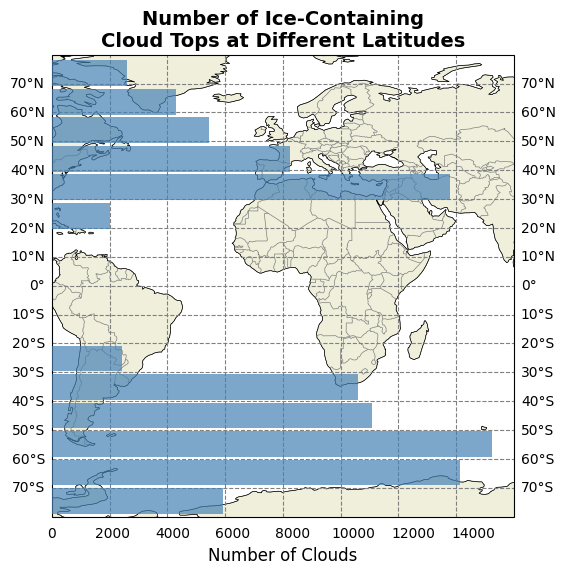

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Dummy data for illustration
# tmp_bin_array = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
# lat_bin_df = {"n_clouds": [5, 15, 20, 10, 25, 15, 10, 5]}

# Calculate midpoints and bin widths
latitudes = [(tmp_bin_array[i] + tmp_bin_array[i + 1] -1 ) / 2 for i in range(len(tmp_bin_array) - 1)]
bin_widths = [tmp_bin_array[i + 1] - tmp_bin_array[i] - 1 for i in range(len(tmp_bin_array) - 1)]

# Create the figure and map axes
fig = plt.figure(figsize=(10, 6))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-80, 80, -80, 80], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.2)
#n_steps=10,
# Add gridlines with specified latitude lines
gl = ax_map.gridlines(
    
    draw_labels=True,
    color='gray',
    linestyle='--',
    linewidth=0.8
)
gl.top_labels = False  # Disable labels on the top
gl.bottom_labels = False  # Disable labels on the bottom
# gl.right_labels = False  # Disable labels on the right

# Add specific latitudes for gridlines (including top and bottom latitudes)
latitudes_to_show = tmp_bin_array  # Include all latitude bin boundaries
gl.ylocator = plt.FixedLocator(latitudes_to_show)

# Create the second Axes for the bar chart, sharing the same extent
ax_bar = fig.add_axes(ax_map.get_position(), zorder=2)  # Align with the map
ax_bar.barh(latitudes, lat_bin_df["n_clouds"], color='#4682B4',
            height=bin_widths, zorder=3, alpha=0.7)  # Use `height` for correct bin widths

# Remove the background of the bar chart (make transparent)
ax_bar.set_facecolor((1, 1, 1, 0))  # RGBA: white background, fully transparent

# Add title and labels for the bar chart
ax_bar.set_title('Number of Ice-Containing\nCloud Tops at Different Latitudes', fontsize=14, fontweight='bold')
ax_bar.set_xlabel('Number of Clouds', fontsize=12)

# Remove the bar graph's y-axis labels
ax_bar.set_yticks([])  # Removes tick marks and labels on y-axis

# Set continuous latitude range for y-axis
ax_bar.set_ylim(tmp_bin_array[0] - 1, tmp_bin_array[-1] + 1)  # Full range of latitude bins

# Format x-axis to show only integer values
ax_bar.xaxis.get_major_locator().set_params(integer=True)

# Hide axes ticks and spines for the bar chart (optional for cleaner overlay)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(left=False, bottom=False)

# Save and show the plot
plt.savefig(os.path.join(GTE_DIR,'/Result_graphs/N_ice_conaining_clouds_by_lat.png'), dpi=400)
plt.show()

